# **ELE 489 HOMEWORK II**
Gürkan DONBALOĞLU /
**2220357131**

In [66]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay

COLUMNS = ['varience', 'skewness', 'kurtosis', 'entropy', 'class']
INPUT_FILE = '/data_banknote_authentication.txt'
SHUFFLED_FILE = 'data_banknote_authentication_shuffled.txt'


#shufle the data multiple times

def shuffle_text_file(seed=42, in_path=INPUT_FILE, out_path=SHUFFLED_FILE):
    with open(in_path, 'r') as f:
        lines = f.readlines()

    np.random.seed(seed)
    np.random.shuffle(lines)
    with open(out_path, 'w') as f:
        for line in lines:
            f.write(line.strip() + '\n') # Strip removes extra \n, then we add it back

# Loads dataset into a pandas DataFrame
def load_dataset(file_path=INPUT_FILE):
    return pd.read_csv(file_path, header=None, names=COLUMNS)

# Splits dataset into training and testing parts (manual split)
def split_dataset(data_frame, test_ratio=0.2):
    X = data_frame.drop('class', axis=1).values
    Y = data_frame['class'].values
    split_idx = int((1 - test_ratio) * len(X))
    X_train, X_test = X[:split_idx], X[split_idx:]
    Y_train, Y_test = Y[:split_idx], Y[split_idx:]
    return X_train, X_test, Y_train, Y_test

#scoring functions

def accuracy_score(y_true, y_pred):
    correct = sum(y_t == y_p for y_t, y_p in zip(y_true, y_pred))
    return correct / len(y_true)

def precision_score(y_true, y_pred):
    TP = sum((yt == 1 and yp == 1) for yt, yp in zip(y_true, y_pred))
    FP = sum((yt == 0 and yp == 1) for yt, yp in zip(y_true, y_pred))
    return TP / (TP + FP)

def recall_score(y_true, y_pred):
    TP = sum((yt == 1 and yp == 1) for yt, yp in zip(y_true, y_pred))
    FN = sum((yt == 1 and yp == 0) for yt, yp in zip(y_true, y_pred))
    return TP / (TP + FN)

def f1_score(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1_score = 2 * precision * recall / (precision + recall)
    return f1_score

# Trains and evaluates the model across multiple random shuffles and parameter combinations
def evaluate_model_seeds(criterions, max_depths, min_samples, seeds = range(10)):
    results = {}
    for seed in seeds:
        shuffle_text_file(seed, in_path=SHUFFLED_FILE, out_path=SHUFFLED_FILE)
        dataset = pd.read_csv(SHUFFLED_FILE, header=None, names=COLUMNS)
        X_train, X_test, Y_train, Y_test = split_dataset(dataset)
        for crt in criterions:
            for depth in max_depths:
                for min_split in min_samples:
                    clf = DecisionTreeClassifier(criterion=crt, max_depth=depth,
                                                 min_samples_split=min_split, random_state=42)
                    clf.fit(X_train, Y_train)
                    y_pred = clf.predict(X_test)
                    key = (crt, depth, min_split)
                    if key not in results:
                        results[key] = []
                    results[key].append({
                        'Accuracy': accuracy_score(Y_test, y_pred),
                        'Precision': precision_score(Y_test, y_pred),
                        'Recall': recall_score(Y_test, y_pred),
                        'F1 Score': f1_score(Y_test, y_pred)
                    })

    return results

# Aggregates and summarizes the evaluation results
def summarize_results(results):
    final_results = []
    for key, scores in results.items():
        avg_accuracy = np.mean([s['Accuracy'] for s in scores])
        avg_precision = np.mean([s['Precision'] for s in scores])
        avg_recall = np.mean([s['Recall'] for s in scores])
        avg_f1 = np.mean([s['F1 Score'] for s in scores])
        final_results.append({
            'Criterion': key[0],
            'Max Depth': key[1],
            'Min Samples Split': key[2],
            'Accuracy': avg_accuracy,
            'Precision': avg_precision,
            'Recall': avg_recall,
            'F1 Score': avg_f1
        })
    df = pd.DataFrame(final_results)
    return df.sort_values(by='F1 Score', ascending=False)

# Visualizes the trained decision tree
def plot_decision_tree(classfier, feature_names):
    plt.figure(figsize=(20, 10))
    plot_tree(classfier, feature_names=feature_names, class_names=['Fake', 'Authentic'], filled=True)
    plt.title('Decision Tree Visualization')
    plt.show()

# Shows feature importance bar plot
def plot_feature_importance(classifier, feature_names):
    importances = classifier.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(8, 5))
    plt.title('Feature Importance')
    plt.bar(range(len(importances)), importances[indices])
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices])
    plt.tight_layout()
    plt.show()


In [67]:
def q2_2_pairplot():
    # for visualizing the features in groups of two
    data = load_dataset(file_path=INPUT_FILE)
    sns.pairplot(data, hue='class', diag_kind='kde')
    plt.suptitle('Pairwise Feature Plots Colored by Class', y=1.02)
    plt.show()


In [68]:
def q2_3():

    # Define parameter
    criterions = ['gini', 'entropy']
    max_depth = [2, 4, 6, 8]
    min_samples = [2, 5, 10]

    # Evaluate model with different parameters
    print("Evaluating decision trees with various hyperparameters...")
    results = evaluate_model_seeds(criterions, max_depth, min_samples)

    # Summarize and display results
    print("Summarizing average results across 10 shuffles...")
    results_df = summarize_results(results)
    print(results_df)

    print("\nTraining and visualizing the final decision tree model...")
    original_df = pd.read_csv(INPUT_FILE, header=None, names=COLUMNS)
    X = original_df.drop('class', axis=1)
    y = original_df['class']

    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    final_model = DecisionTreeClassifier(criterion='gini', max_depth=4, min_samples_split=2, random_state=42)
    final_model.fit(X_train, Y_train)

    from sklearn.metrics import classification_report
    y_pred = final_model.predict(X_test)
    print("\nClassification Report:")
    print(classification_report(Y_test, y_pred, target_names=['Fake', 'Authentic']))

    ConfusionMatrixDisplay.from_estimator(final_model, X_test, Y_test, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.show()


In [62]:
def q2_4():
    '''
    If you want to see a different data tree, simply change the variables of the DecisionTreeClassifier function.
    '''
    original_df = pd.read_csv(INPUT_FILE, header=None, names=COLUMNS)
    X = original_df.drop('class', axis=1)
    y = original_df['class']

    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    final_model = DecisionTreeClassifier(criterion='gini', max_depth=4, min_samples_split=2, random_state=42)
    final_model.fit(X_train, Y_train)
    plot_decision_tree(final_model, X.columns)

In [69]:
def q2_5():
    '''
    If you changed the DecisionTreeClassifier function in the previous question, you should make the same change here.
    '''

    original_df = pd.read_csv(INPUT_FILE, header=None, names=COLUMNS)
    X = original_df.drop('class', axis=1)
    y = original_df['class']

    X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    final_model = DecisionTreeClassifier(criterion='gini', max_depth=4, min_samples_split=2, random_state=42)
    final_model.fit(X_train, Y_train)
    plot_feature_importance(final_model, X.columns)

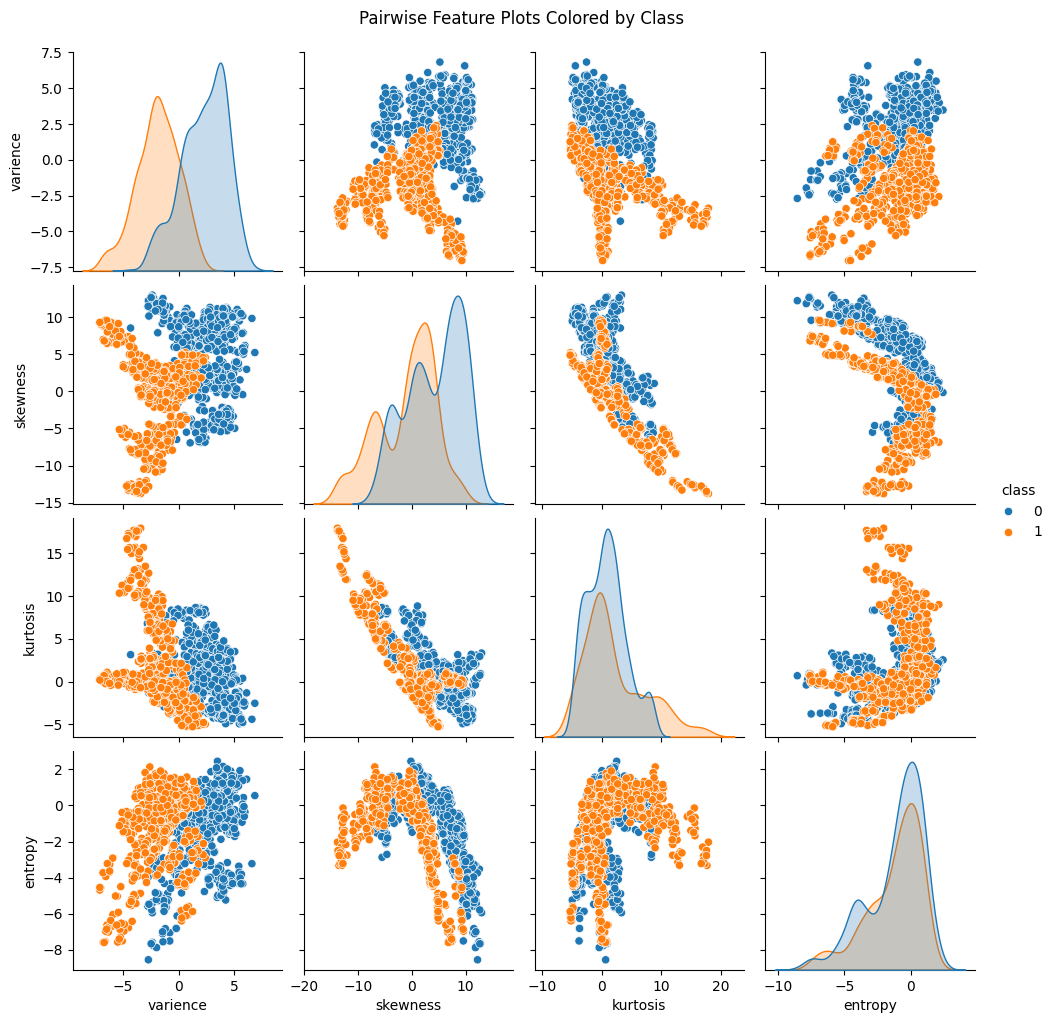

In [70]:
def main():
    # For creating shuffled data
    shuffle_text_file(42, in_path=INPUT_FILE, out_path=SHUFFLED_FILE)
    # === Q2.2: Pairplot Visualization ===
    q2_2_pairplot()

if __name__ == '__main__':
    main()




Evaluating decision trees with various hyperparameters...
Summarizing average results across 10 shuffles...
   Criterion  Max Depth  Min Samples Split  Accuracy  Precision    Recall  \
21   entropy          8                  2  0.985091   0.977272  0.988455   
22   entropy          8                  5  0.984000   0.977222  0.985896   
23   entropy          8                 10  0.984000   0.978815  0.984283   
9       gini          8                  2  0.982909   0.971705  0.988708   
18   entropy          6                  2  0.982545   0.972005  0.987562   
19   entropy          6                  5  0.982182   0.972768  0.985896   
20   entropy          6                 10  0.981091   0.972690  0.983476   
10      gini          8                  5  0.981091   0.968312  0.987860   
11      gini          8                 10  0.981091   0.968312  0.987860   
6       gini          6                  2  0.980364   0.970651  0.983315   
7       gini          6                  5  0

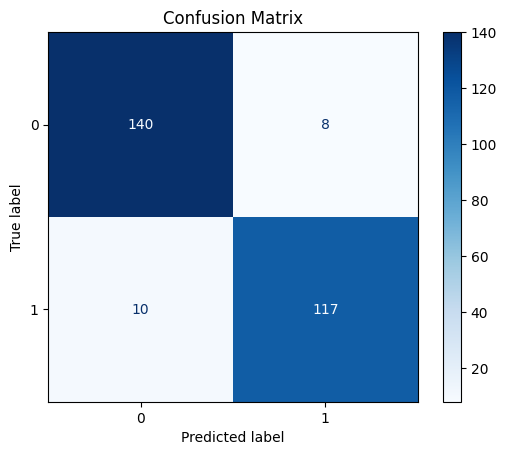

In [71]:
# === Q2.3: Hyperparameter Evaluation ===
'''
When you run this code, you will be dealing with the average values ​​of 10 different shuffled data each time.
'''
q2_3()


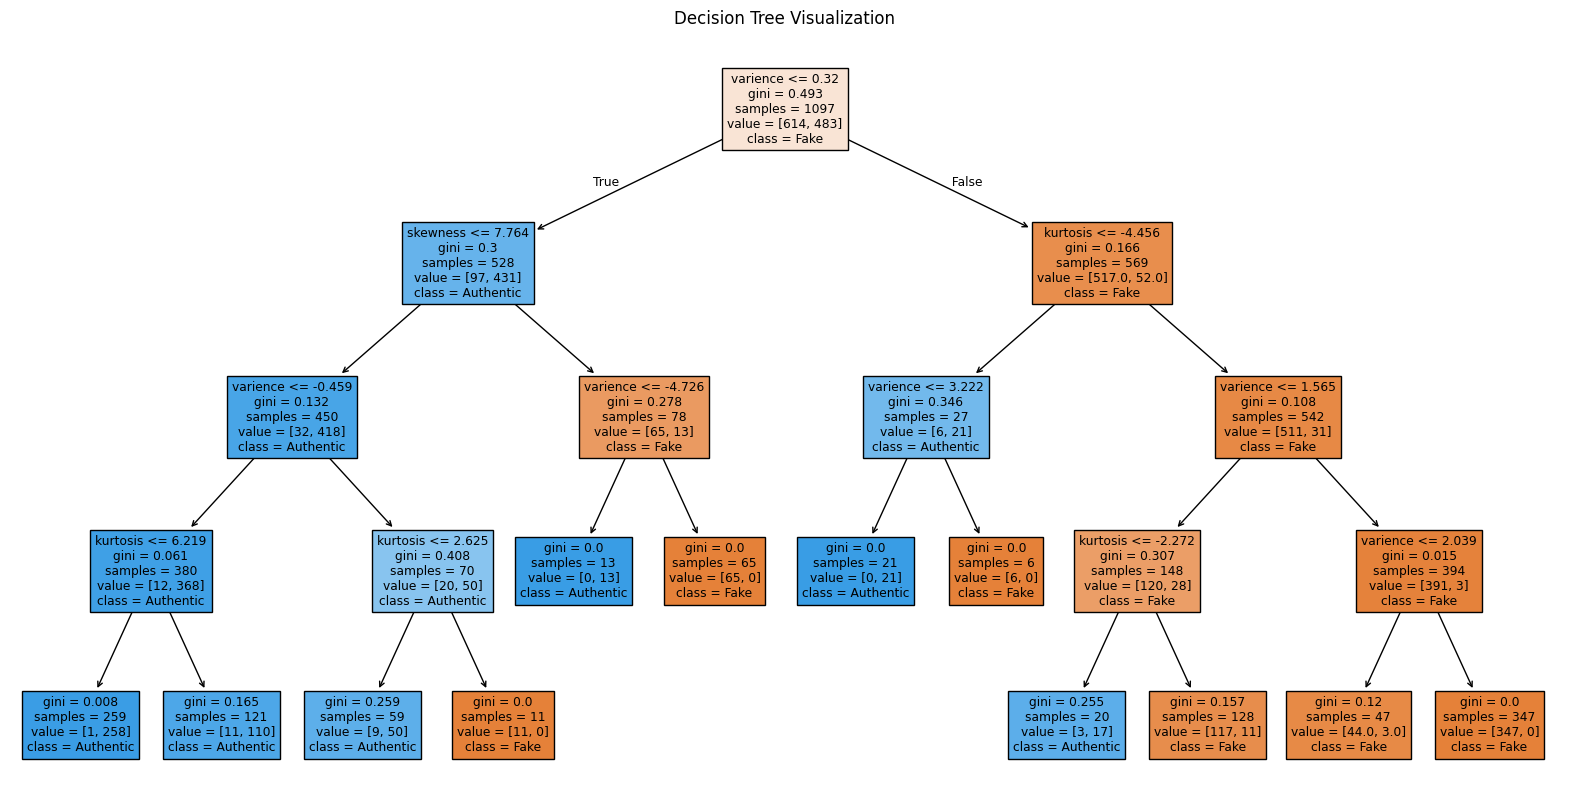

In [72]:
# === Q2.4 Plotting Decision Tree ===
q2_4()


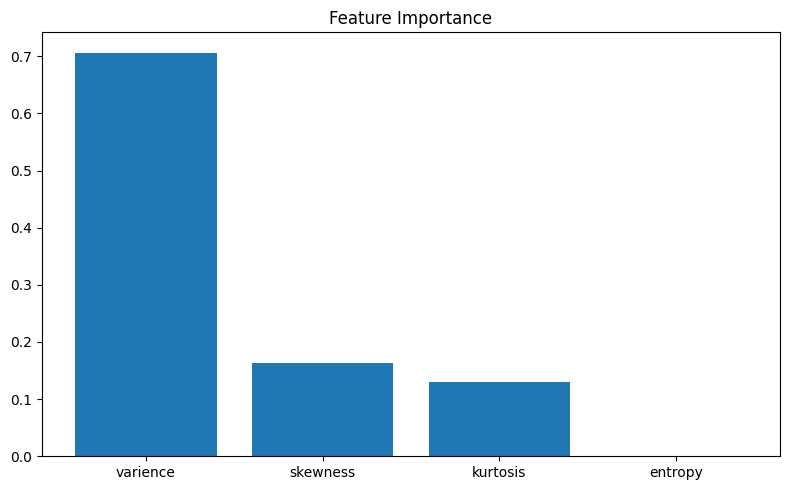

In [73]:
# === Q2.4 Plotting Feature Importance
q2_5()
